In [12]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from utils.basic_units import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [13]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [14]:
k = 10 # Top 10% highest l2-magnitude filters

In [15]:
def get_F_angle(F):
	
	F = tf.expand_dims(F, -1)
	_, a = getSymAntiSymTF(F)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, 0]
	theta = getSobelTF(F)[:, 0]
	#print(a_mag.shape)
	x =a_mag*np.cos((theta))
	y = a_mag*np.sin((theta))


	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eigh(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)

	new_vec =    ((e_vec[0] * x + e_vec[1]*y)/(e_vec[0]**2+e_vec[1]**2))[:, None] * e_vec
	new_vec = np.mean(new_vec, axis=0)

	'''if any((np.sign(new_vec)-np.sign(e_vec))!=0) :
		print("DOWN", e_vec, new_vec)
	else:
		print("OK", e_vec, new_vec)'''
	'''if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1'''
		#print(e_val, e_vec)
	#print(np.arctan2(e_vec[1], e_vec[0]))
	return np.arctan2(new_vec[1], new_vec[0])

FL (3, 3, 64, 64)
AMAG (64, 64)
(-3.141425609588623, 3.1395232677459717)
-3.141592653589793
['-$\\pi$', '0', '$\\pi$']


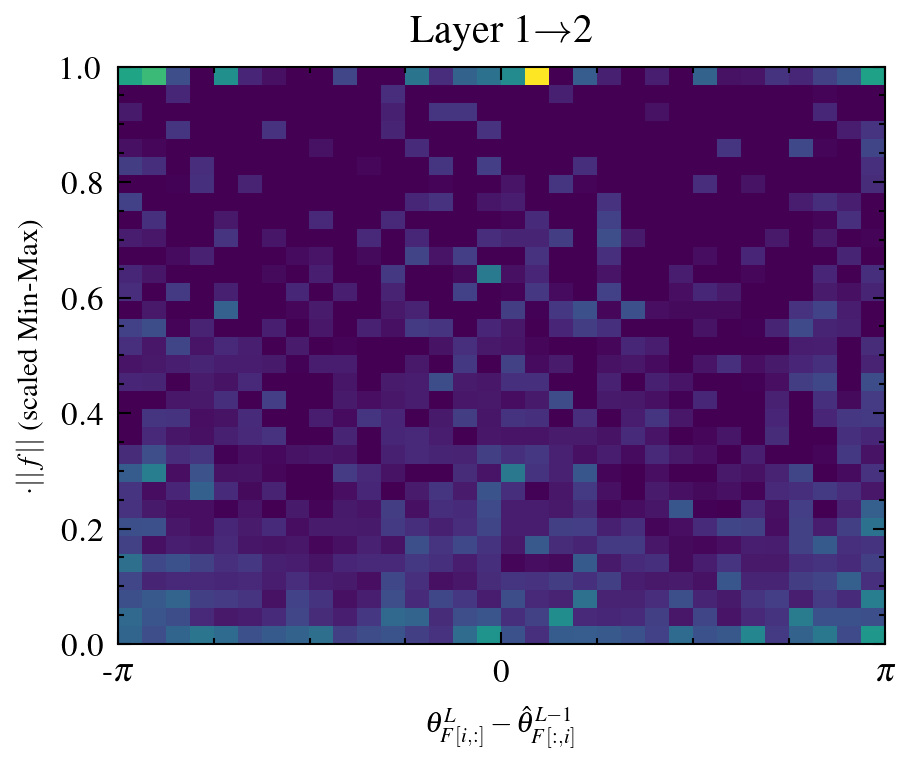

In [23]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

 
l_num = 1
#top10Fprev=topKfilters(model, l_num-1, k=20)
filtersLprev = get_filter(model, l_num-1)#[:,:,:,top10Fprev]
#top10F=topKfilters(model, l_num, k=20)
filtersL = get_filter(model, l_num)#[:,:,:,top10F]
filtersL = filtersL


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L-1
sp, ap = getSymAntiSymTF(filtersLprev)
e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
betap = e_ap/(e_ap+e_sp)


# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
e_a = reduce_euclidean_norm(a, axis=[0,1])**2
e_s = reduce_euclidean_norm(s, axis=[0,1])**2
dc = np.sign(np.mean(filtersL, axis=(0,1)))

beta = e_a/(e_a+e_s)



e = reduce_euclidean_norm(filtersL, axis=[0,1])
a_mag = reduce_euclidean_norm(a, axis=[0,1]).numpy()
theta = getSobelTF(filtersL)
 
#mag = (e_a - reduce_min(e_a, axis=0, keepdims=True))/(reduce_max(e_a, axis=0, keepdims=True) - reduce_min(e_a, axis=0, keepdims=True))
mag = (a_mag - reduce_min(a_mag, axis=0, keepdims=True))/(reduce_max(a_mag, axis=0, keepdims=True) - reduce_min(a_mag, axis=0, keepdims=True))
print("AMAG", mag.shape)


#find lims :
cos_sim = []
m = []
weight = []
theta_F_prev = []
theta_F_prev = getDominantAngle(filtersLprev)
'''for i in range(filtersLprev.shape[-1]):
	theta_F_prev.append(get_F_angle(filtersLprev[:,:,:,i]))
theta_F_prev = np.array(theta_F_prev)'''
for i in range(filtersL.shape[-1]):
	#: = tf.where(tf.greater(dc[:, i],0))[:,0].numpy()
	mag = (a_mag[:,i]**2 - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))/(reduce_max(a_mag[:,i]**2 , axis=0, keepdims=True) - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))
	#print((theta_F_prev[:] - theta[:,i]).shape, mag.shape )
	cos_sim.extend(theta_F_prev - theta[:,i])#(np.cos(theta_F_prev - theta[i,:])))
	m.extend(mag.numpy())
	weight.extend((e[:,i]**2 - reduce_min(e[:,i]**2 , axis=0, keepdims=True))/(reduce_max(e[:,i]**2 , axis=0, keepdims=True) - reduce_min(e[:,i]**2 , axis=0, keepdims=True)))
weight = np.array(weight)
m = np.array(m)




'''print("M", len(m))
m, t= rejection_sampling(m, cos_sim, 5000)
print(cos_sim)'''
#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)

fig, ax= plt.subplots(1,1)

data = np.array(cos_sim)
data  = np.arctan2(np.sin(data), np.cos(data)) # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,m, bins=32, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 


In [24]:
beta.shape

TensorShape([64, 64])

<BarContainer object of 16 artists>

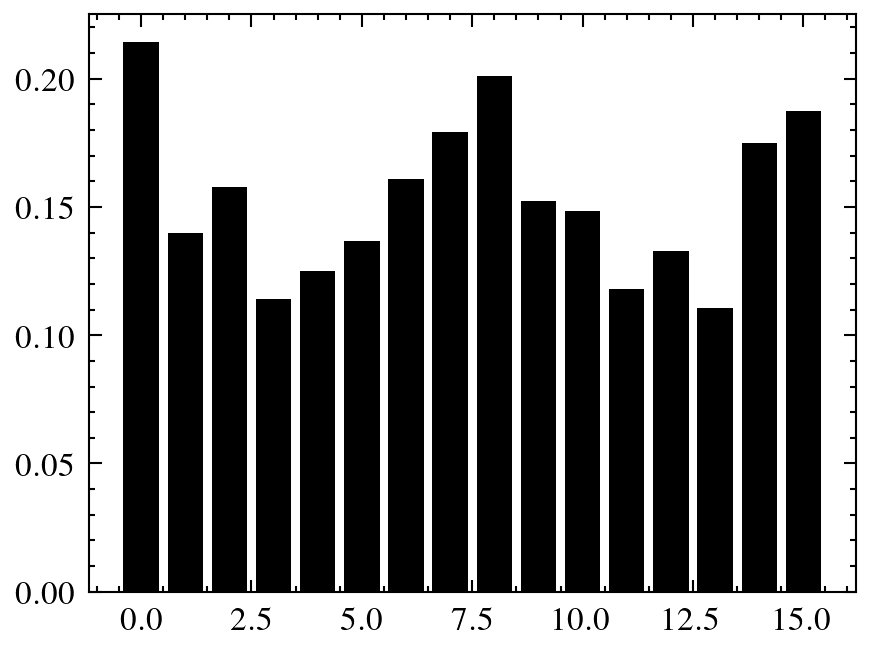

In [25]:

vals = ax.hist2d(data,m, bins=16, weights=m)
unweighted_vals = ax.hist2d(data,m, bins=16)

w_counts = vals[0]

uw_counts = unweighted_vals[0]

sum_intensities = tf.reduce_sum(w_counts, axis=1)/tf.reduce_sum(uw_counts, axis=1)
#plt.bar(sum_intensities, vals[1])
vals[1].shape
plt.bar(list(range(16)), sum_intensities)

(array([43.56583023, 34.49071884, 23.65507126, 16.15871048, 21.30441284,
        14.36748409, 11.62255669,  9.60381508, 10.60830593, 14.67821693,
        12.07225323, 20.31852913, 19.74915886, 20.82201767, 21.88031578,
        29.9299469 , 29.67178535, 29.06632614, 19.18569756, 22.67420959,
        21.38512039, 12.04303741, 13.31446075,  9.24588394, 15.02405357,
        10.86554813, 11.02095222, 13.50871944, 21.95729637, 27.0645237 ,
        28.41633797, 41.92171097]),
 array([-3.1414256e+00, -2.9451458e+00, -2.7488663e+00, -2.5525866e+00,
        -2.3563070e+00, -2.1600273e+00, -1.9637477e+00, -1.7674681e+00,
        -1.5711884e+00, -1.3749087e+00, -1.1786290e+00, -9.8234946e-01,
        -7.8606975e-01, -5.8979011e-01, -3.9351046e-01, -1.9723082e-01,
        -9.5117092e-04,  1.9532847e-01,  3.9160812e-01,  5.8788776e-01,
         7.8416741e-01,  9.8044711e-01,  1.1767267e+00,  1.3730063e+00,
         1.5692861e+00,  1.7655658e+00,  1.9618454e+00,  2.1581249e+00,
         2.3544047e+00

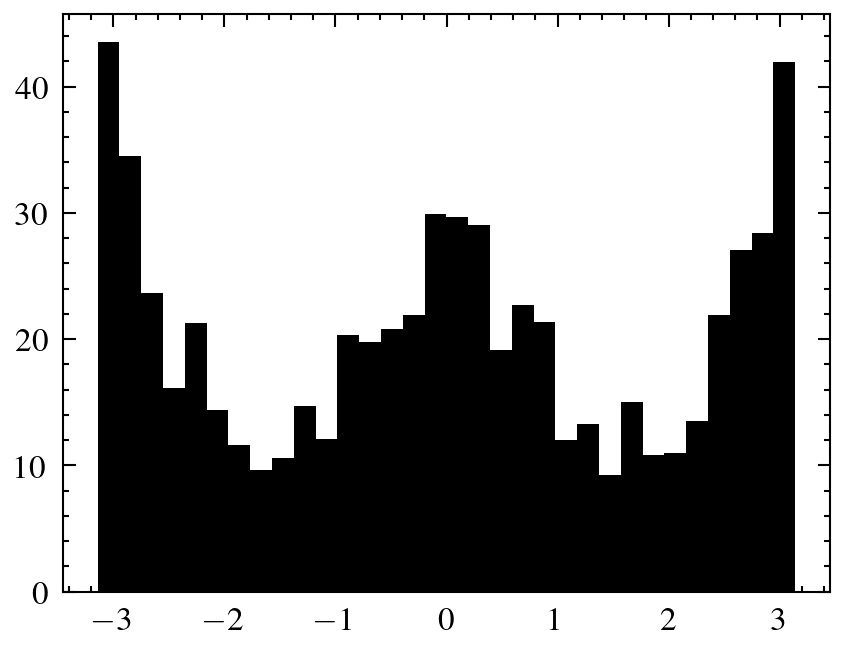

In [19]:
plt.hist(data, bins=32, weights=m)

(array([364., 285., 226., 186., 202., 237., 252., 289., 292., 275., 225.,
        191., 195., 222., 280., 375.]),
 array([-3.1414256e+00, -2.7488663e+00, -2.3563070e+00, -1.9637477e+00,
        -1.5711884e+00, -1.1786290e+00, -7.8606975e-01, -3.9351046e-01,
        -9.5117092e-04,  3.9160812e-01,  7.8416741e-01,  1.1767267e+00,
         1.5692861e+00,  1.9618454e+00,  2.3544047e+00,  2.7469640e+00,
         3.1395233e+00], dtype=float32),
 <BarContainer object of 16 artists>)

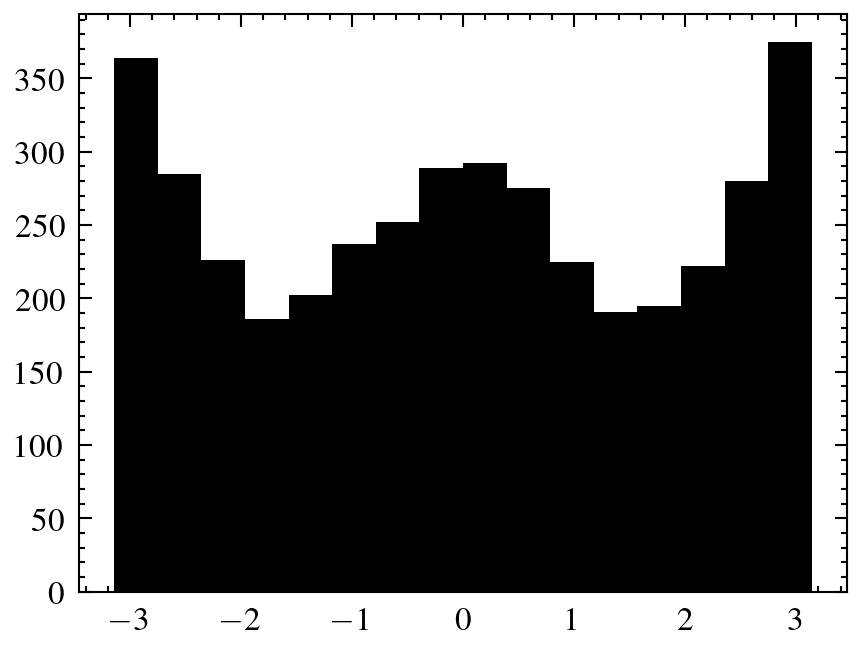

In [20]:
plt.hist(data, bins=16)

In [21]:
weight.shape

(4096,)

(array([54.86325836, 36.33213425, 29.66648865, 19.55386162, 19.7009201 ,
        28.01702881, 35.74676895, 45.24213028, 43.37829208, 38.32872391,
        28.14433098, 20.13547134, 21.71127319, 22.30008507, 42.42685699,
        50.7780838 ]),
 array([-3.1414256e+00, -2.7488663e+00, -2.3563070e+00, -1.9637477e+00,
        -1.5711884e+00, -1.1786290e+00, -7.8606975e-01, -3.9351046e-01,
        -9.5117092e-04,  3.9160812e-01,  7.8416741e-01,  1.1767267e+00,
         1.5692861e+00,  1.9618454e+00,  2.3544047e+00,  2.7469640e+00,
         3.1395233e+00], dtype=float32),
 <BarContainer object of 16 artists>)

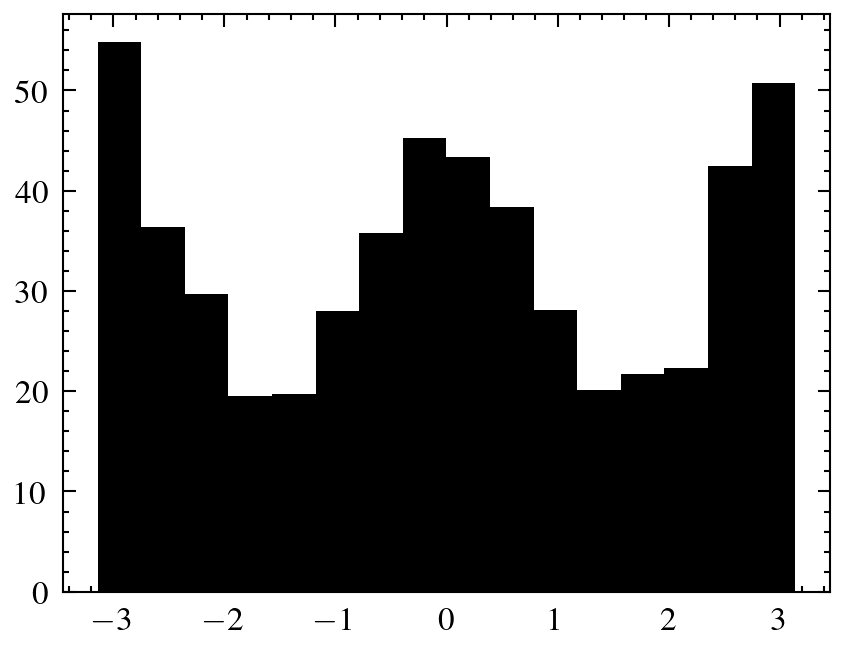

In [22]:
plt.hist(data, bins=16, weights=weight)